In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ragas
import yaml
import os, sys, datetime
from tqdm import tqdm
import pandas as pd
## load keys from keys.env 
from dotenv import load_dotenv
load_dotenv(dotenv_path='keys.env')
# load the keys from the environment variables
KEYS = {
    'openai': os.getenv('OPENAI_API_KEY')
}
os.environ['OPENAI_API_KEY'] = KEYS['openai']


In [3]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas import SingleTurnSample 
from ragas.metrics import ResponseRelevancy, Faithfulness, AspectCritic, FactualCorrectness, BleuScore, RougeScore, SemanticSimilarity
from ragas.metrics._string import NonLLMStringSimilarity, DistanceMeasure
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:

def load_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
    
class Labels(object):
    def __init__(self, labels, list_ds_urls, list_metadata_fields):
        self.labels = labels
        self.list_ds_urls = list_ds_urls
        self.list_metadata_fields = list_metadata_fields

    def get(self, url, field):
        assert url in self.list_ds_urls, f"URL {url} not found in labels."
        assert field in self.list_metadata_fields, f"Field {field} not found in metadata fields." 

        if field in self.labels[url].keys():
            return self.labels[url][field]
        else:
            print(f"Field {field} not found in labels for URL {url}. Available fields: {self.list_metadata_fields}")
            print(f"Available fields for {url}: {self.labels[url].keys()}")
            return [None]
        
    def __getitem__(self, url):
        assert url in self.list_ds_urls, f"URL {url} not found in labels."
        return self.labels[url]
    
    def __len__(self):
        return len(self.labels)
    
    def keys(self):
        return self.labels.keys()
    def values(self):
        return self.labels.values()
    def items(self):
        return self.labels.items()
    def __contains__(self, url):
        return url in self.labels
    
    def __repr__(self):
        return f"Labels({len(self.labels)} URLs, {len(self.list_metadata_fields)} metadata fields: {self.list_metadata_fields})"

def load_pred_and_annot(fp_pred, fp_annot='outputs/ground_truth_metadata_annotations-2025-05-30.yaml'):
    labels_annot = load_yaml(fp_annot)
    labels_pred = load_yaml(fp_pred)
    assert set(labels_annot.keys()) == set(labels_pred.keys()), "Keys in annotation and prediction files do not match."
    metadata_fields_annot = list(list(labels_annot.values())[0].keys())
    for _, vals in labels_pred.items():
        assert set(vals.keys()).difference(set(metadata_fields_annot).union(set(['Landing page']))) == set(), "Prediction fields contain unexpected keys."
    list_ds_urls = list(labels_annot.keys())
    labels_annot = Labels(labels_annot, list_ds_urls, metadata_fields_annot)
    labels_pred = Labels(labels_pred, list_ds_urls, metadata_fields_annot)
    print(f"Loaded {len(labels_annot.labels)} annotations and predictions.")
    return labels_annot, labels_pred, (list_ds_urls, metadata_fields_annot)

labels_annot, labels_pred, (list_ds_urls, list_metadata_fields) = load_pred_and_annot(fp_pred='outputs/2025-05-28/clean_entity_type_map.yaml')


Loaded 15 annotations and predictions.


Text(0.5, 0, 'Fraction of datasets with annotations')

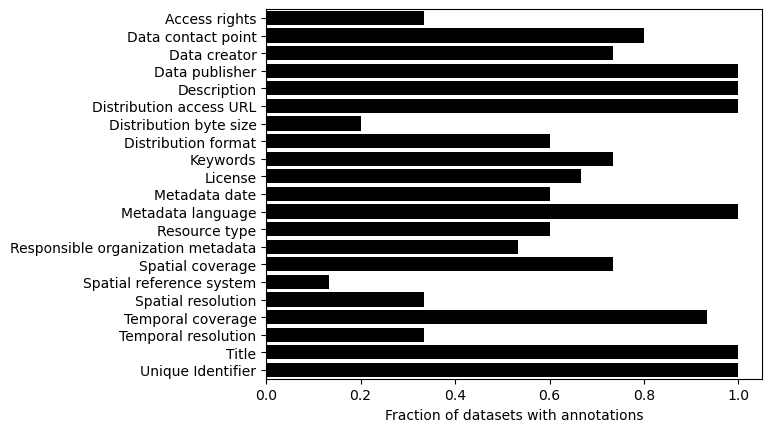

In [5]:
df_annot_present = pd.DataFrame({m: [labels_annot.get(url, m)[0] != 'N/A' for url in labels_annot.keys()] for m in list_metadata_fields})
sns.barplot(data=df_annot_present, orient='h', errorbar=None, color='black')
plt.xlabel('Fraction of datasets with annotations')

In [6]:
for l_name, l in zip(['annotated', 'predicted'], [labels_annot, labels_pred]):
    for url, vals in l.items():
        for meta_key, meta_vals in vals.items():
            if len(meta_vals) > 1:
                print(f"Multiple values for {l_name}: {meta_key} in {url}: {meta_vals}")

In [7]:

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-3.5-turbo"))
evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [8]:
list_metadata_fields

['Access rights',
 'Data contact point',
 'Data creator',
 'Data publisher',
 'Description',
 'Distribution access URL',
 'Distribution byte size',
 'Distribution format',
 'Keywords',
 'License',
 'Metadata date',
 'Metadata language',
 'Resource type',
 'Responsible organization metadata',
 'Spatial coverage',
 'Spatial reference system',
 'Spatial resolution',
 'Temporal coverage',
 'Temporal resolution',
 'Title',
 'Unique Identifier']

In [152]:
field_pred

'2016-11-01'

In [101]:
test_faith = True
test_correct = True
test_relevancy = True
test_nonllm_similarity = True
test_embeddings_similarity = True

col_evaluate = 'Spatial resolution'  # Column to evaluate, e.g., 'Description', 'Title', etc.

ds_scores = {x: [] for x in ['url', 'relevancy', 'bleu', 'faithfulness', 'correctness', 'levenshtein', 'rouge', 'embedding_similarity']}

for url in tqdm(list_ds_urls):
    ds_scores['url'].append(url)

    field_annot = labels_annot.get(url, col_evaluate)[0]
    assert field_annot is not None, f"Field {col_evaluate} not found in annotations for URL {url}."
    if type(field_annot) is datetime.date:
        field_annot = field_annot.strftime('%Y-%m-%d')
    field_pred = labels_pred.get(url, col_evaluate)[0]
    if field_pred is None:
        field_pred = 'N/A'
 
    assert type(field_pred) is str, f"Field {col_evaluate} in predictions for URL {url} is not a string."
    assert type(field_annot) is str, f"Field {col_evaluate} in annotations for URL {url} is not a string."
    
    test_data = SingleTurnSample(
        user_input=f'What is the {col_evaluate} of this dataset?',
        response=field_pred,
        reference=field_annot
        # reference=labels_annot.get(url, 'Description')[0]
    )

    test_data_faith = SingleTurnSample(
        user_input=f'What is the {col_evaluate} of this dataset?',
        response=field_pred,
        retrieved_contexts=[field_annot]
    )
    
    test_data_f1 = SingleTurnSample(
        response=field_pred,
        reference=field_annot
    )

    if test_nonllm_similarity:
        levenshtein_scorer = NonLLMStringSimilarity(distance_measure=DistanceMeasure.LEVENSHTEIN)
        levenshtein_sim = levenshtein_scorer.single_turn_score(test_data_f1)
        ds_scores['levenshtein'].append(levenshtein_sim)
        rouge_scorer = RougeScore(rouge_type='rougeL', mode='fmeasure')
        rouge_score = rouge_scorer.single_turn_score(test_data)
        ds_scores['rouge'].append(rouge_score)
        blue_scorer = BleuScore()
        blue_score = blue_scorer.single_turn_score(test_data)
        ds_scores['bleu'].append(blue_score)

    if test_relevancy:
        rel_scorer = ResponseRelevancy(llm=evaluator_llm, embeddings=evaluator_embeddings)
        rel = await rel_scorer.single_turn_ascore(test_data)
        ds_scores['relevancy'].append(rel)
    
    if test_faith:
        faith_scorer = Faithfulness(llm=evaluator_llm)
        faith = await faith_scorer.single_turn_ascore(test_data_faith)
        ds_scores['faithfulness'].append(faith)

    if test_correct:
        correct_scorer = FactualCorrectness(llm=evaluator_llm, mode='f1', atomicity='high', coverage='low')
        correct = await correct_scorer.single_turn_ascore(test_data_f1)
        ds_scores['correctness'].append(correct)

    if test_embeddings_similarity:
        embeddings_scorer = SemanticSimilarity(embeddings=evaluator_embeddings)
        embedding_similarity = await embeddings_scorer.single_turn_ascore(test_data_f1)
        ds_scores['embedding_similarity'].append(embedding_similarity)

ds_scores = {k: v for k, v in ds_scores.items() if len(v) == len(list_ds_urls)}  # Ensure all lists are of equal length

df_scores = pd.DataFrame(ds_scores)
df_scores 

 60%|██████    | 9/15 [01:18<00:46,  7.83s/it]

Field Spatial resolution not found in labels for URL https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en: dict_keys(['Data contact point', 'Data creator', 'Description', 'Distribution format', 'Keywords', 'License', 'Metadata language', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [02:02<00:00,  8.16s/it]


,url,relevancy,bleu,faithfulness,correctness,levenshtein,rouge,embedding_similarity
0,https://datahuiswadden.openearth.nl/geonetwork...,0.000000,0.0,0.0,0.00,0.076923,0.0,0.847967
1,https://datahuiswadden.openearth.nl/geonetwork...,0.000000,0.0,0.0,0.00,0.000000,0.0,0.838017
2,https://datahuiswadden.openearth.nl/geonetwork...,0.000000,0.0,0.0,0.67,0.076923,0.0,0.833252
3,https://developers.google.com/earth-engine/dat...,0.902593,0.0,1.0,0.00,0.096774,0.0,0.840312
4,https://lifesciences.datastations.nl/dataset.x...,0.000000,0.0,0.0,0.00,1.000000,1.0,1.000000
5,https://lpdaac.usgs.gov/products/mod09a1v061/,0.793990,0.0,1.0,0.00,1.000000,1.0,1.000000
6,https://stac.ecodatacube.eu/blue_glad.landsat....,0.000000,0.0,1.0,0.00,1.000000,1.0,1.000000
7,https://stac.ecodatacube.eu/green_glad.landsat...,0.000000,0.0,1.0,0.00,1.000000,1.0,1.000000
8,https://stac.ecodatacube.eu/ndvi_glad.landsat....,0.000000,0.0,0.0,0.00,0.000000,0.0,0.790424
9,https://stac.ecodatacube.eu/veg_quercus.robur_...,0.000000,0.0,0.0,0.00,1.000000,1.0,1.000000


For missing data:
1. Does the A indicate the info was not available? Yes -> 1
2. No -> Relevancy + Faith from ANNOT TO TEXT??

In [155]:

# sns.scatterplot(data=df_scores, x='rouge', y='levenshtein', sizes=(20, 200), alpha=0.6)

In [112]:
url = list_ds_urls[3]  # Example URL to check

field_annot = labels_annot.get(url, col_evaluate)[0]
assert field_annot is not None, f"Field {col_evaluate} not found in annotations for URL {url}."
field_pred = labels_pred.get(url, col_evaluate)[0]
if field_pred is None:
    field_pred = ''
    
print(f"Dataset URL: {url}")
print(f"Predicted: {field_pred}")
print(f"Annotated: {field_annot}")

df_scores[df_scores['url'] == url]

Dataset URL: https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002
Predicted: 30-meter (m) spatial resolution
Annotated: 30m


,url,relevancy,bleu,faithfulness,correctness,levenshtein,rouge,embedding_similarity
3,https://developers.google.com/earth-engine/dat...,0.902593,0.0,1.0,0.0,0.096774,0.0,0.840312
